# Data Preparation

In [62]:
import os
import json
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pymysql
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import skew, kurtosis, probplot

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from arch import arch_model

In [63]:
# 1) load your creds
load_dotenv()
user     = os.getenv("MYSQL_USER")
raw_pw   = os.getenv("MYSQL_PASSWORD")
password = urllib.parse.quote_plus(raw_pw)
host     = os.getenv("MYSQL_HOST")
port     = os.getenv("MYSQL_PORT")
db       = os.getenv("MYSQL_DATABASE")

# 2) build the engine
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}")

In [64]:
df_tf = pd.read_sql_query(
    "SELECT DISTINCT timeframe FROM ohlcv ORDER BY timeframe;",
    con=engine
)
timeframes = df_tf['timeframe'].tolist()

def tf_to_minutes(tf):
    unit_minutes = {
        'm':1,
        'h':60,
        'd':60*24,
        'w':60*24*7
    }
    value, unit = int(tf[:-1]), tf[-1]
    return value*unit_minutes[unit]

# Sort timeframe in ascending order
timeframes = sorted(timeframes, key=tf_to_minutes)
timeframes

['1m', '3m', '5m', '15m', '30m', '1h', '4h', '6h', '12h', '1d', '1w']

## Example

In [65]:
query = f"""
SELECT datetime, open, high, low, close, volume
FROM ohlcv
WHERE timeframe = '1h'
ORDER BY timestamp
"""
df = pd.read_sql_query(query, con=engine)
df.set_index('datetime', inplace=True)
print(df.dtypes)

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object


In [66]:
df.describe()

,open,high,low,close,volume
count,33269.000000,33269.000000,33269.000000,33269.000000,33269.000000
mean,46099.112352,46280.557445,45912.874663,46100.741666,412.640789
std,23273.847460,23367.389997,23178.491771,23274.856717,554.555765
min,15656.540000,15770.000000,15484.340000,15656.540000,0.029893
25%,26921.960000,26990.000000,26870.360000,26921.960000,76.982611
50%,41767.690000,41931.530000,41616.820000,41770.000000,214.790199
75%,62459.770000,62721.740000,62161.080000,62459.920000,559.853216
max,108322.460000,109900.000000,107794.040000,108322.460000,15206.868300


# 1. Data Validation

Tests: 
1. Datetime Integrity & Missing Intervals
- week timeframe had 198 missing week time -> drop data with week timeframe
2. Basic Value Sanity Checks between :
- no major issues
3. Cross-Field Consistency (aggregation test for adjacent timeframes)
- Upscaled 1m data to timeframe 1h and 4h by creating OHLCV data.
- no major issues: every values were within 1%
- when i set accuracy constraint as within 0.1%, there are differences particularly in volume data

In [67]:
ohlcv = {}
for tf in timeframes:
    query = f"""
    SELECT datetime, open, high, low, close, volume
    FROM ohlcv
    WHERE timeframe = '{tf}'
    ORDER BY timestamp
    """
    df = pd.read_sql_query(query, con=engine)
    df.set_index('datetime', inplace=True)
    ohlcv[tf] = df

# Container for anomaly reports
report = {}

# Define frequency mapping
freq_map = {
    '1m': 'min',
    '3m': '3min',
    '5m': '5min',
    '15m': '15min',
    '30m': '30min',
    '1h': 'h',
    '4h': '4h',
    '12h': '12h',
    '1d': 'D',
    '1w': 'W',
}

# 1) Timestamp Integrity & Missing Intervals
timestamps_diff = {}
for tf, df in ohlcv.items():
    idx = df.index
    # Monotonicity & uniqueness
    report[f"{tf}_monotonic"] = idx.is_monotonic_increasing
    report[f"{tf}_unique"] = idx.is_unique

    # Otherwise build the expected full range
    full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
    missing = full_range.difference(idx)

    report[f"{tf}_missing_count"] = len(missing)
    report[f"{tf}_missing_samples_head"] = missing.astype(str).tolist()

# 2) Basic Value Sanity Checks
for tf, df in ohlcv.items():
    cond_price = (df['high'] >= df[['open','close','low']].max(axis=1)) & \
                 (df['low']  <= df[['open','close','high']].min(axis=1))
    cond_volume = df['volume'] >= 0
    cond_positive = (df[['open','high','low','close']] > 0).all(axis=1)
    invalid = df.index[~(cond_price & cond_volume & cond_positive)]
    report[f"{tf}_value_violations"] = len(invalid)
    report[f"{tf}_value_violation_samples"] = invalid.astype(str).tolist()

# 3) Cross-Field Consistency (aggregation test for adjacent timeframes)
pairs = [('1m','1h'), ('1m','4h')]
for low_tf, high_tf in pairs:
    df_low  = ohlcv[low_tf].copy()
    df_high = ohlcv[high_tf]

    # resample the lower timeframe to the higher timeframe
    agg = df_low.resample(freq_map[high_tf]).agg({
        'open':   'first',
        'high':   'max',
        'low':    'min',
        'close':  'last',
        'volume': 'sum'
    })

    # Compare to the “official” higher timeframe
    common_idx = df_high.index.intersection(agg.index)
    mismatches = {}
    for col in ['open','high','low','close','volume']:
        diff = (agg.loc[common_idx, col] - df_high.loc[common_idx, col])/df_high.loc[common_idx, col] > 1e-2
        mismatches[col] = int(diff.sum())
        mismatches_samples = agg[diff] - df_high[diff]
       
    report[f"{low_tf}_to_{high_tf}_mismatches"] = mismatches

# 7) Save anomaly report to JSON
with open('validation_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("Data validation complete. See validation_report.json for details.")




/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_40581/226434498.py:39: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_40581/226434498.py:39: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_40581/226434498.py:39: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=tf)
/var/folders/3y/9m0_h3_50mbgtyzs2dx_pmc80000gn/T/ipykernel_40581/226434498.py:39: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start=idx.min(), end=idx.max(), freq=

Data validation complete. See validation_report.json for details.


# 2. Description Statistics & Return Distribution for log return in closed price and volume.

1. log return in closed price is roughly symmetric, near-Gaussian but have fat tail.
2. volume is highly skewed, heavy-tailed, non-negative

## A. log return in closed price

In [ ]:
rets = {}
for tf in timeframes:
    query = f"""
    SELECT timestamp, close
    FROM ohlcv
    WHERE timeframe = '{tf}'
    ORDER BY timestamp
    """
    df = pd.read_sql_query(query, con=engine, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    df['ret'] = np.log(df['close'] / df['close'].shift(1))
    rets[tf] = df['ret'].dropna()

stats = []
for tf, series in rets.items():
    stats.append({
        'timeframe': tf,
        'mean': series.mean(),
        'std': series.std(),
        'skew': skew(series),
        'kurtosis': kurtosis(series)
    })
stats_df = pd.DataFrame(stats)
print("Descriptive Statistics:")
print(stats_df)
    
n = len(timeframes)
cols = 4
rows = math.ceil(n / cols)

Descriptive Statistics:
   timeframe          mean       std      skew    kurtosis
0         1m  4.847337e-07  0.000795 -0.273562  116.350507
1         3m  9.800510e-07  0.001613 -0.084904   90.280380
2         5m  2.518084e-06  0.002139 -0.922980  107.906163
3        15m  7.246309e-06  0.003017 -0.437497   50.471648
4        30m  1.450003e-05  0.004238 -0.376501   21.404091
5         1h  2.894845e-05  0.005919 -0.157904   12.098270
6         4h  1.152040e-04  0.011714 -0.105154    7.064387
7         6h  1.724454e-04  0.014452 -0.041134    6.531422
8        12h  3.446498e-04  0.020863 -0.151711    5.016134
9         1d  6.892551e-04  0.029197 -0.179701    3.375157
10        1w  4.742666e-03  0.073482 -0.216299    1.298690


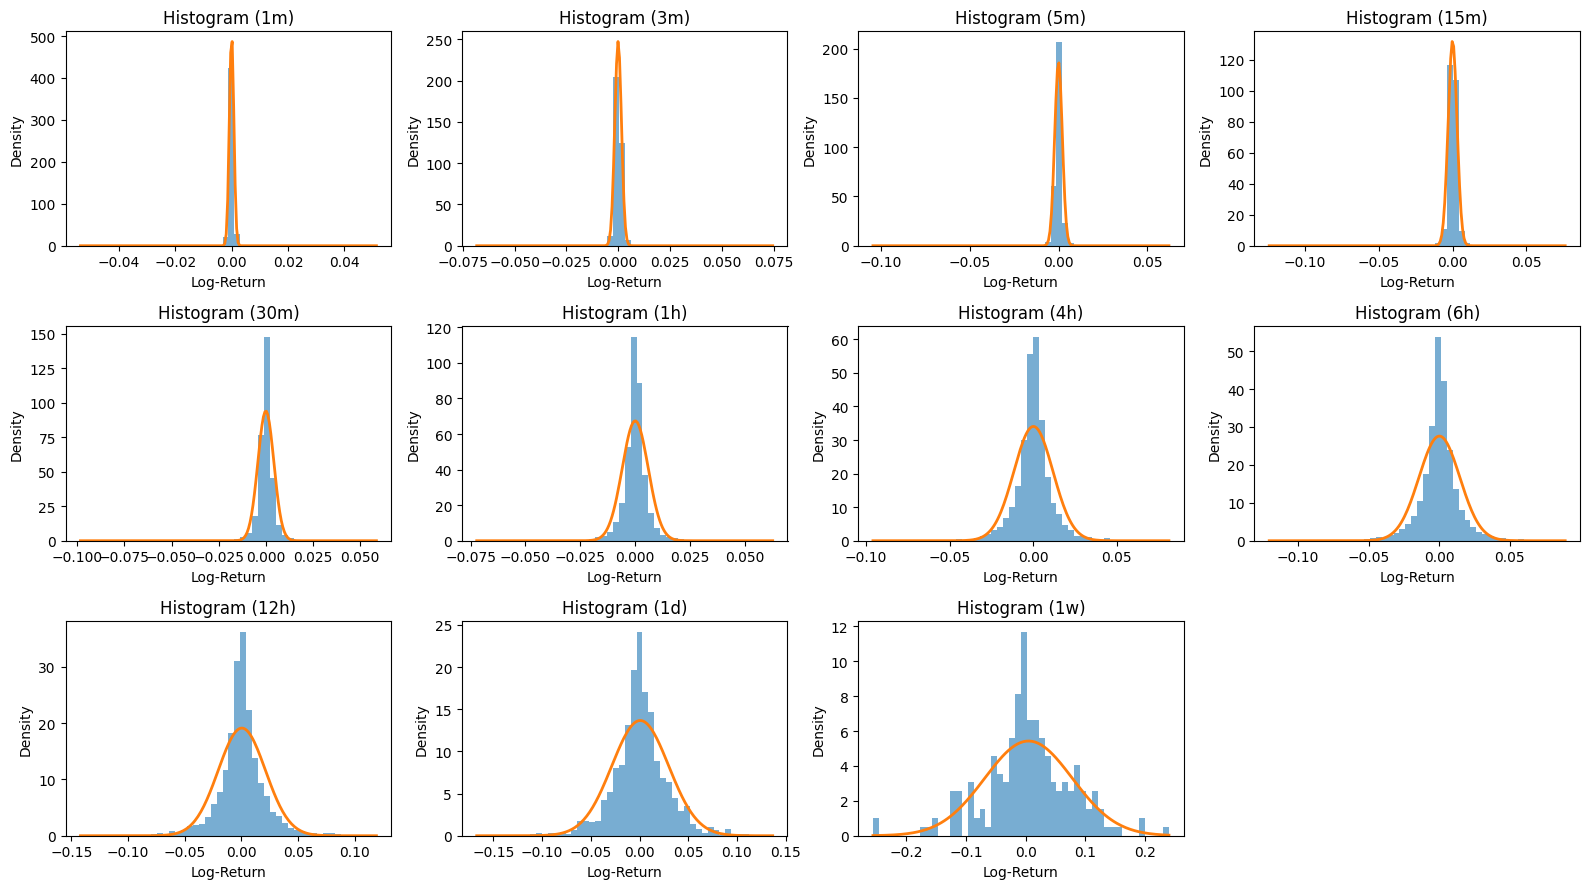

In [69]:
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    series = rets[tf]

    # plot histogram + normal overlay
    ax.hist(series, bins=50, density=True, alpha=0.6)
    x = np.linspace(series.min(), series.max(), 200)
    pdf = (1 / (series.std() * np.sqrt(2 * np.pi))) * \
          np.exp(-((x - series.mean())**2) / (2 * series.std()**2))
    ax.plot(x, pdf, linewidth=2)

    ax.set_title(f"Histogram ({tf})")
    ax.set_xlabel("Log-Return")
    ax.set_ylabel("Density")

# turn off any unused axes
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


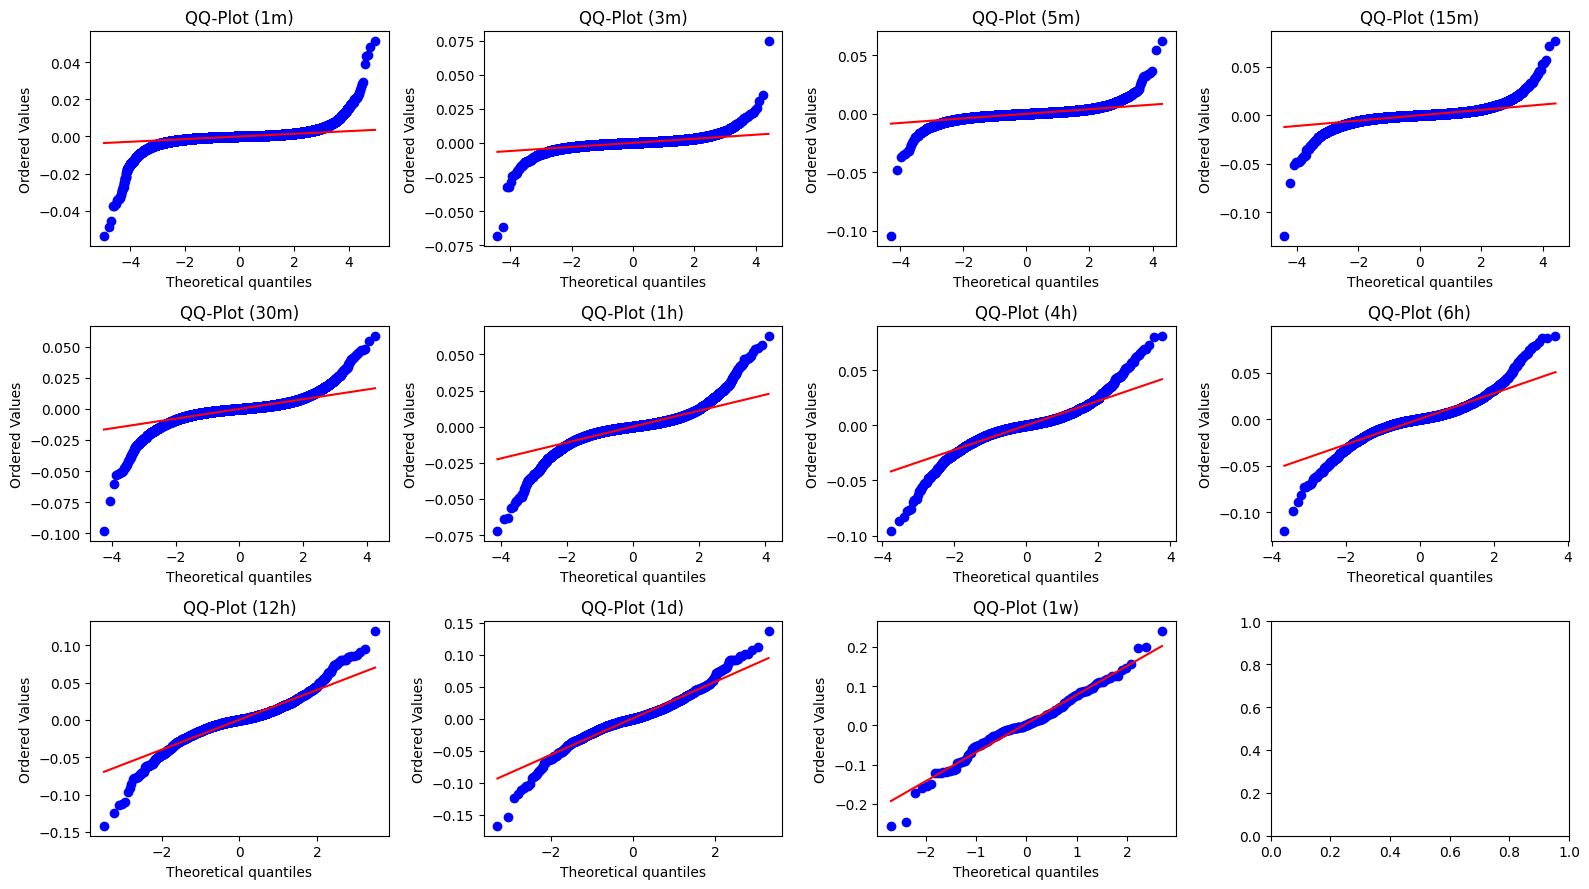

In [70]:
# 2) QQ-Plots vs. Gaussian
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    probplot(rets[tf], dist="norm", plot=ax)
    ax.set_title(f"QQ-Plot ({tf})")
fig.tight_layout()
plt.show()



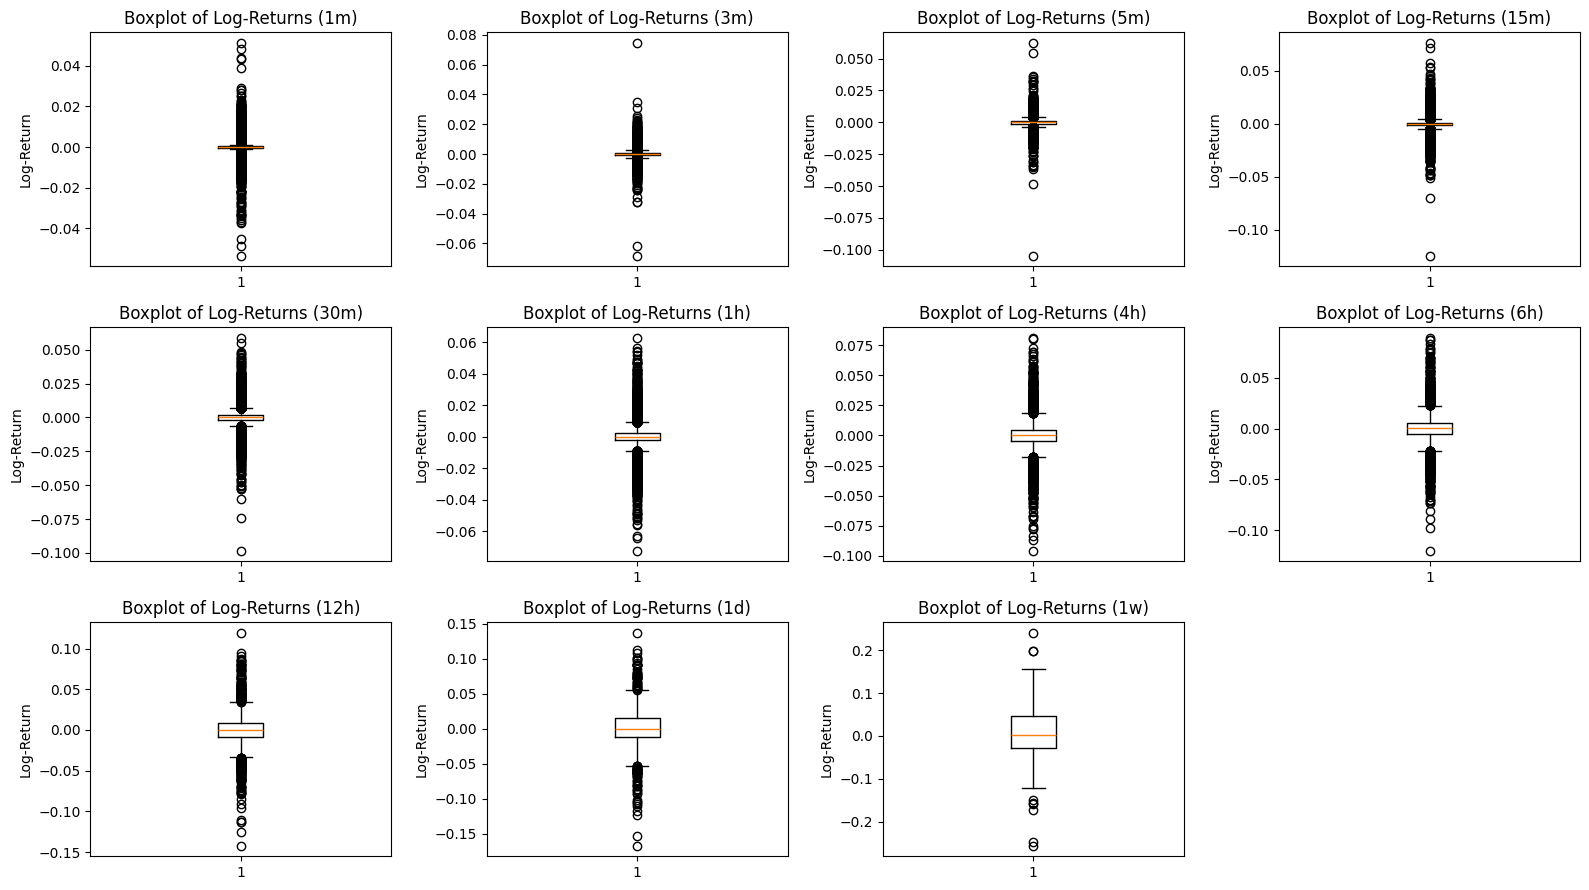

In [71]:
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    ax.boxplot(rets[tf])
    ax.set_title(f"Boxplot of Log-Returns ({tf})")
    ax.set_ylabel("Log-Return")

# Remove any unused subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

## B. Volume

In [74]:
vols = {}
for tf in timeframes:
    query = f"""
    SELECT timestamp, volume
    FROM ohlcv
    WHERE timeframe = '{tf}'
    ORDER BY timestamp
    """
    df = pd.read_sql_query(query, con=engine, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    vols[tf] = df['volume'].dropna()

stats = []
for tf, series in vols.items():
    stats.append({
        'timeframe': tf,
        'mean': series.mean(),
        'std': series.std(),
        'skew': skew(series),
        'kurtosis': kurtosis(series)
    })
stats_df = pd.DataFrame(stats)
print("Descriptive Statistics:")
print(stats_df)

Descriptive Statistics:
   timeframe          mean           std       skew    kurtosis
0         1m      6.877351     13.876782  13.673232  515.689593
1         3m      2.654538      5.051986   6.167093   75.302764
2         5m      4.115128      7.343988   5.966664   76.494564
3        15m    103.428632    158.037660   7.175418  138.074587
4        30m    206.894445    296.452096   5.706723   81.121227
5         1h    412.640789    554.555765   4.651351   53.703196
6         4h   1650.421516   1930.430241   2.726215   14.993340
7         6h   2475.781109   2796.187645   2.383740   10.227281
8        12h   4950.669440   5244.719156   1.959227    6.298233
9         1d   9897.779388   9895.263577   1.728416    4.691651
10        1w  68986.021999  58958.327914   0.953830    0.098515


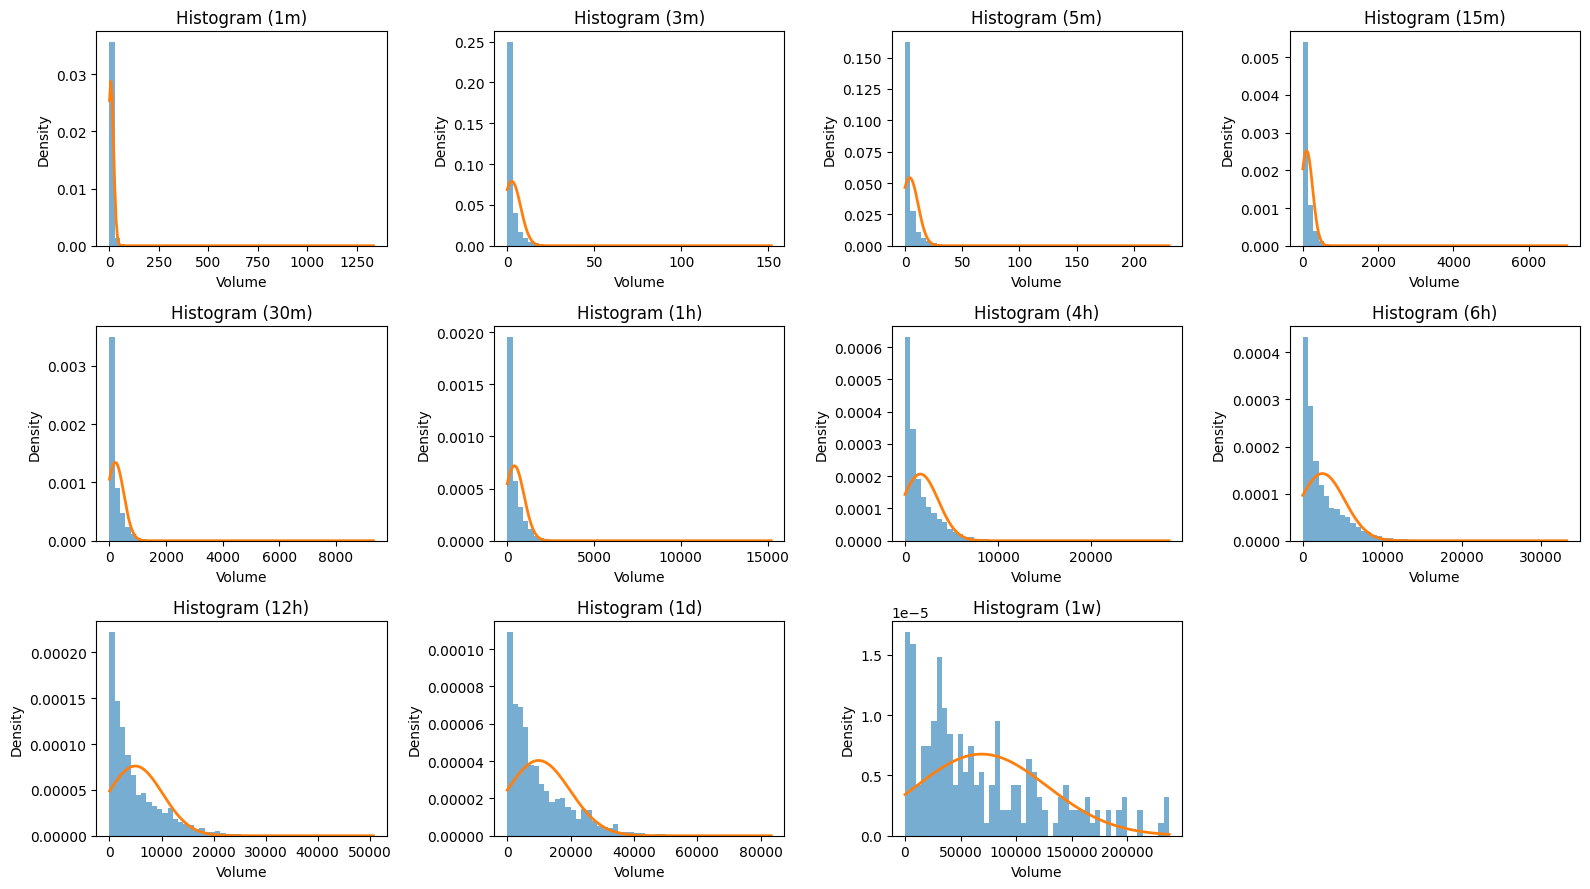

In [75]:
n = len(timeframes)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    series = vols[tf]

    # plot histogram + normal overlay
    ax.hist(series, bins=50, density=True, alpha=0.6)
    x = np.linspace(series.min(), series.max(), 200)
    pdf = (1 / (series.std() * np.sqrt(2 * np.pi))) * \
          np.exp(-((x - series.mean())**2) / (2 * series.std()**2))
    ax.plot(x, pdf, linewidth=2)

    ax.set_title(f"Histogram ({tf})")
    ax.set_xlabel("Volume")
    ax.set_ylabel("Density")

# turn off any unused axes
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


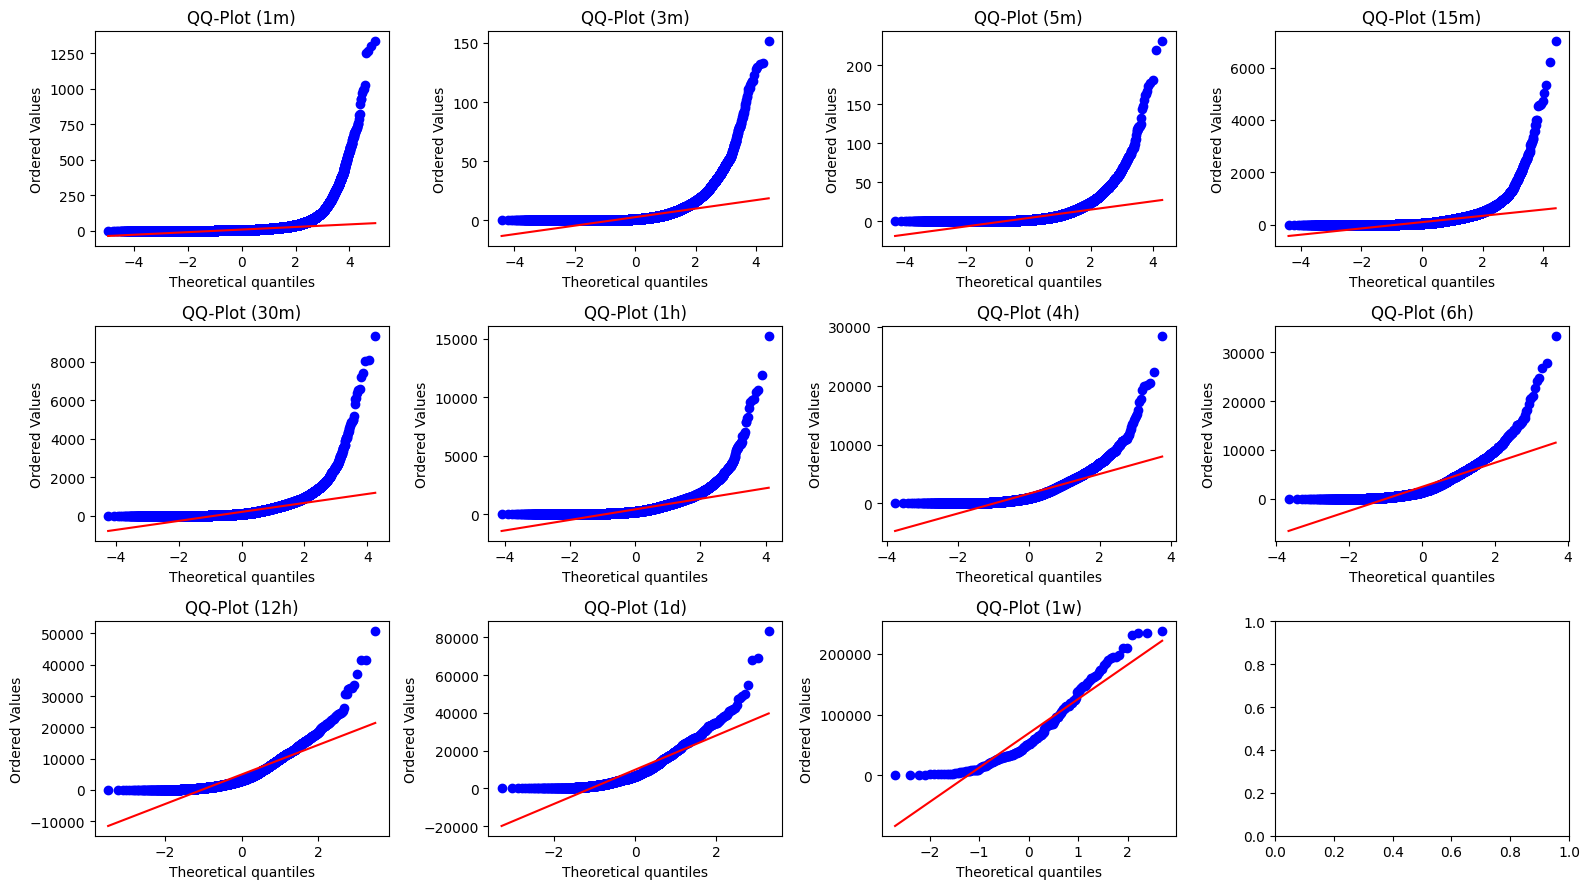

In [76]:
# 2) QQ-Plots vs. Gaussian
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    probplot(vols[tf], dist="norm", plot=ax)
    ax.set_title(f"QQ-Plot ({tf})")
fig.tight_layout()
plt.show()



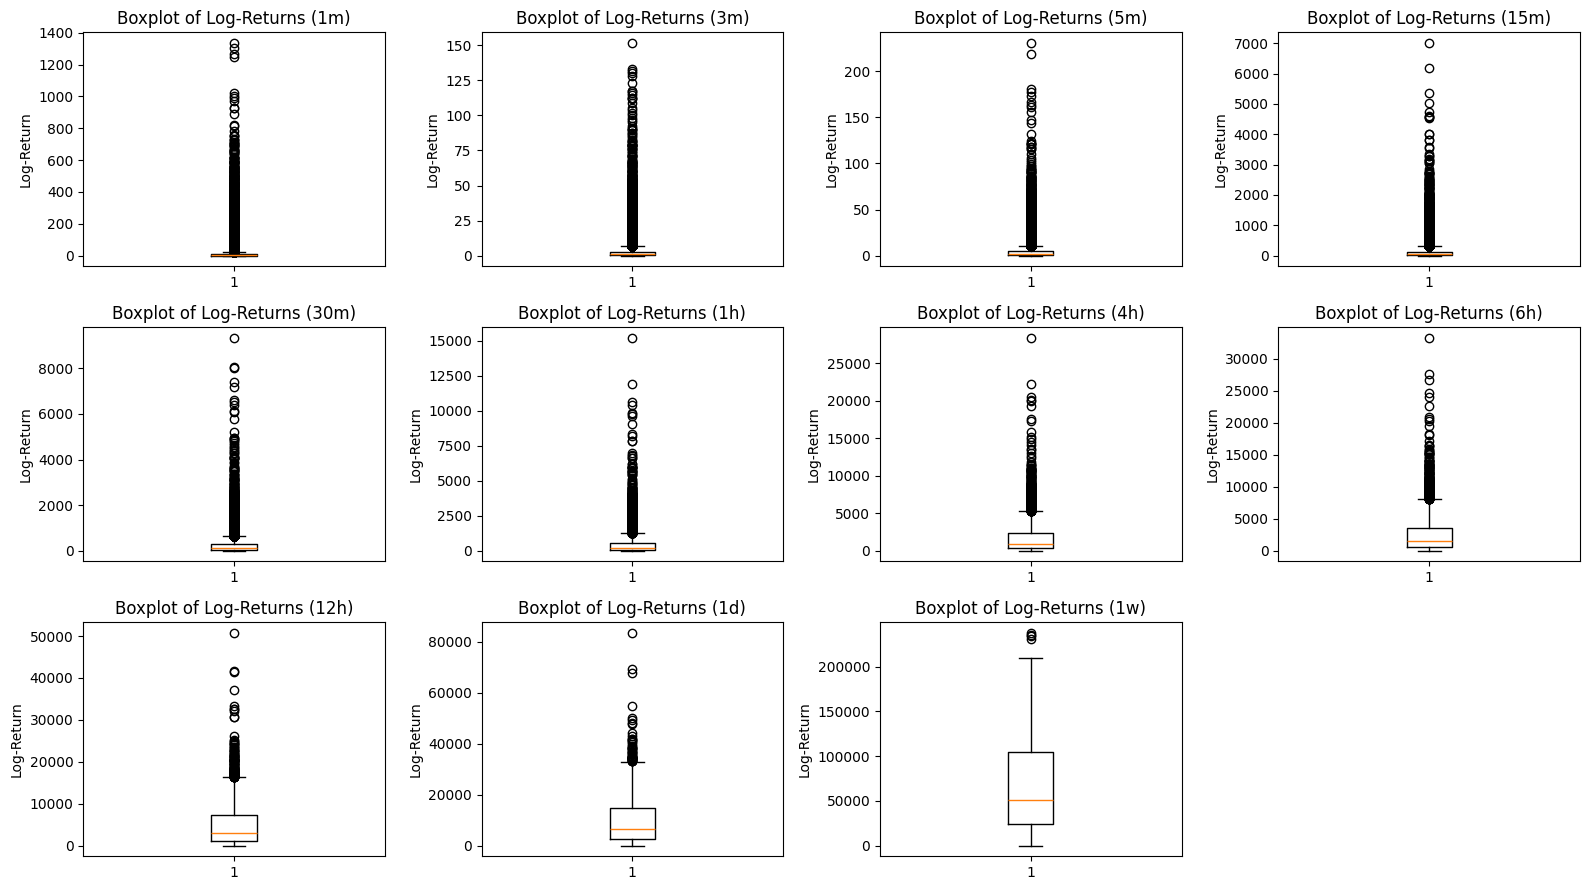

In [78]:
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
axes = axes.flatten()

for i, tf in enumerate(timeframes):
    ax = axes[i]
    ax.boxplot(vols[tf])
    ax.set_title(f"Boxplot of Log-Returns ({tf})")
    ax.set_ylabel("Log-Return")

# Remove any unused subplots
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

## 4. Outlier & Anomaly Detection (log returns z-score and IQR for volume)

- log return is in near normal distribution and volume is non-normal distribution
- use z-normalization to standardize log return
- use 1.5 x IQR to standardize log return (as IQR is robust to distributions in extreme cases)
- 

In [ ]:
import requests
import pandas as pd
import numpy as np

def fetch_ohlcv_bybit(symbol: str, interval: str, limit: int = 200) -> pd.DataFrame:
    """
    Fetch OHLCV from Bybit public API.
    
    :param symbol: e.g. "BTCUSDT"
    :param interval: one of ['1', '3', '5', '15', '30', '60', '120', '240', '360', '720', 'D', 'W']
                     (minutes for numeric, 'D' = daily, 'W' = weekly)
    :param limit:   number of bars to retrieve (max 200)
    :return:        DataFrame indexed by timestamp with columns [open, high, low, close, volume]
    """
    url = "https://api.bybit.com/v5/market/kline"
    params = {
        "symbol": symbol,
        "interval": interval,
        "limit": limit
    }
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()["result"]
    
    # Build DataFrame
    df = pd.DataFrame(data)
    # Bybit returns timestamps as integer seconds since epoch
    df["timestamp"] = pd.to_datetime(df["open_time"], unit="s", utc=True)
    df = df.set_index("timestamp")[["open", "high", "low", "close", "volume"]]
    
    # Convert strings to floats
    df = df.astype(float)
    return df

# --- usage example and outlier detection ---

symbol     = "BTCUSDT"
interval   = "5"   # 5-minute bars
limit      = 1000  # pull the last 1,000 bars

# 1) Fetch
df_5m = fetch_ohlcv_bybit(symbol, interval, limit=limit)

# 2) Compute log-returns and z-scores
rets = np.log(df_5m["close"] / df_5m["close"].shift(1)).dropna()
mu, sigma = rets.mean(), rets.std()
z = (rets - mu) / sigma

# 3) Identify outliers at |z| > 5
mask = z.abs() > 5
outlier_times  = z[mask].index
outlier_returns = rets.loc[outlier_times]

print(f"Found {len(outlier_times)} 5-min bars with |z|>5:")
print(outlier_returns)

# 4) (Optional) Pull neighboring bars for context
context = df_5m.loc[outlier_times - pd.Timedelta(minutes=5) : 
                    outlier_times + pd.Timedelta(minutes=5)]
print("\nContext around each outlier:")
print(context)


HTTPError: 404 Client Error: Not Found for url: https://api.bybit.com/v2/public/kline?symbol=BTCUSDT&interval=5&limit=1000

In [82]:
# 4) Outlier & Anomaly Detection (returns z-score and IQR for volume)
for tf, df in ohlcv.items():
    
    # Compute log-returns
    ret = np.log(df['close'] / df['close'].shift(1)).dropna()
    mu, sigma = ret.mean(), ret.std()
    z = (ret - mu) / sigma
    mask = z.abs() > 5
    outlier_times = mask[mask].index
    outlier_closes = df.loc[outlier_times,'close']
    print(outlier_closes)

    # # Volume IQR rule
    # vol = df['volume']
    # q1, q3 = vol.quantile(0.25), vol.quantile(0.75)
    # iqr = q3 - q1
    # vol_anom = (vol < (q1 - 1.5*iqr)) | (vol > (q3 + 1.5*iqr))


datetime
2021-07-05 17:43:00    33190.14
2021-07-05 18:00:00    33920.14
2021-07-06 00:05:00    33850.24
2021-07-06 00:11:00    34085.18
2021-07-06 04:04:00    34189.23
                         ...   
2025-04-13 21:39:00    83060.40
2025-04-14 14:39:00    85597.00
2025-04-14 15:02:00    84807.10
2025-04-15 14:18:00    85187.10
2025-04-21 00:26:00    85926.50
Name: close, Length: 7078, dtype: float64
datetime
2021-07-06 04:03:00    34355.51
2021-07-06 11:45:00    34260.72
2021-07-06 12:09:00    34201.30
2021-07-08 07:39:00    32547.19
2021-07-14 03:24:00    31816.04
                         ...   
2022-04-18 17:09:00    40197.69
2022-04-18 18:15:00    40836.27
2022-04-21 22:27:00    40280.00
2022-04-23 23:33:00    39406.15
2022-04-24 16:54:00    39528.25
Name: close, Length: 434, dtype: float64
datetime
2021-07-06 04:05:00    34588.02
2021-07-06 09:10:00    34503.81
2021-07-14 03:20:00    31862.50
2021-07-14 09:00:00    32170.81
2021-07-14 13:10:00    32801.09
                         .